# With Neural Network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline


Using TensorFlow backend.


In [2]:
train =pd.read_csv('train_trec07p_Ham_Spam_All.csv',delimiter=',',encoding='latin-1')
test=pd.read_csv("test_trec07p_Ham_Spam_All.csv")
DataS = pd.concat([train,test], axis=0)
DataS.head()

,Ham_Spam_email_text,Class
0,[b'from help bounces math ethz ch sun aprretur...,1.0
1,[b'from owner larryking ktwarwic speedy uwater...,1.0
2,[b'from bounce debian legal ktwarwic speedy uw...,1.0
3,[b'from sugar bounces org mon aprreturn pathre...,1.0
4,[b'from help bounces math ethz ch mon aprretur...,1.0


In [3]:
print('Length of the dataset', len(DataS))

Length of the dataset 75419


# By getting features and Class

In [4]:
X=DataS.Ham_Spam_email_text.astype('str')
y=DataS.Class

# Spliting Dataset into 80% Training and 20% Testing

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [6]:
max_words = 2000
max_len = 100
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train.astype('str'))
sequences = tok.texts_to_sequences(X_train.astype('str'))
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [7]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [8]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
____________________________________________

In [9]:
model.fit(sequences_matrix,y_train,batch_size=100,epochs=2,
          validation_split=0.1)



Train on 54301 samples, validate on 6034 samples
Epoch 1/2
54301/54301 [==============================] - 92s 2ms/step - loss: 0.0552 - accuracy: 0.9817 - val_loss: 0.0270 - val_accuracy: 0.9917
Epoch 2/2
54301/54301 [==============================] - 85s 2ms/step - loss: 0.0242 - accuracy: 0.9940 - val_loss: 0.0286 - val_accuracy: 0.9914


# For testing

In [10]:
test_sequences = tok.texts_to_sequences(X_test.astype('str'))
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [11]:
accr = model.evaluate(test_sequences_matrix,y_test)

15084/15084 [==============================] - 9s 574us/step


In [31]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(100 * accr[0],100 * accr[1]))

Test set
  Loss: 2.315
  Accuracy: 99.350


In [16]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(test_sequences_matrix)]

In [17]:
confusion_matrix(y_test,y_predict)

array([[10038,    21],
       [   77,  4948]], dtype=int64)

In [32]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))
print("F1: {:.2f}%".format(100 * f1_score(y_test, y_predict)))


Precision: 99.58%
Recall: 98.47%
F1: 99.02%


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_predict)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     10059
         1.0       1.00      0.98      0.99      5025

    accuracy                           0.99     15084
   macro avg       0.99      0.99      0.99     15084
weighted avg       0.99      0.99      0.99     15084





In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(y_test,y_predict)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[10038    21]
 [   77  4948]]


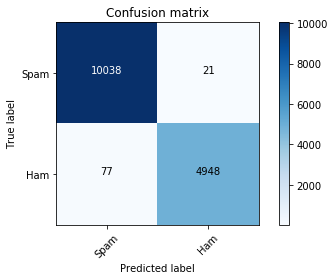

In [28]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Spam','Ham'], normalize=False,
                      title='Confusion matrix')